## Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import torch

import STAHD

os.environ['R_HOME'] = "/usr/lib/R/"
os.environ['R_USER'] = "~/.conda/envs/STAHD/lib/python3.8/site-packages/rpy2"
            
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri

used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

from STAHD.ST_utils import set_seed
set_seed(2024)

## Load Data

In [2]:
adata = sc.read_h5ad('/home/dwang/data/spatial_3D/10x_xenium/xenium_whole_adult_mouse/mouse_1_million.h5ad')

# Constructing the spatial network
STAHD.Cal_Spatial_Net(adata, rad_cutoff=20)  # the spatial network are saved in adata.uns[‘adj’]
# STAHD.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
adata.uns['edgeList'] = np.nonzero(adata.uns['adj'])

# Normalization
# sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# adata = adata[:, adata.var['highly_variable']]

------Calculating spatial graph...
The graph contains 16283552 edges, 1298870 cells.
12.5367 neighbors per cell on average.


## Running STAHD

In [4]:
##
strna = STAHD.train_STAHD(adata, hidden_dims=[50, 30], verbose=True, batch_size=4096, device=used_device)

STAHD(
  (conv1): GATConv(5010, 50, heads=1)
  (conv2): GATConv(50, 30, heads=1)
  (conv3): GATConv(30, 50, heads=1)
  (conv4): GATConv(50, 5010, heads=1)
)
Pretrain with STAHD...


100%|██████████| 1000/1000 [3:55:18<00:00, 14.12s/it] 


## Clustering and Visualization

In [15]:
leiden_resolution = 0.06 
sc.pp.neighbors(strna, use_rep='STAHD', random_state=666)
sc.tl.leiden(strna, random_state=666, key_added="leiden", resolution=leiden_resolution)


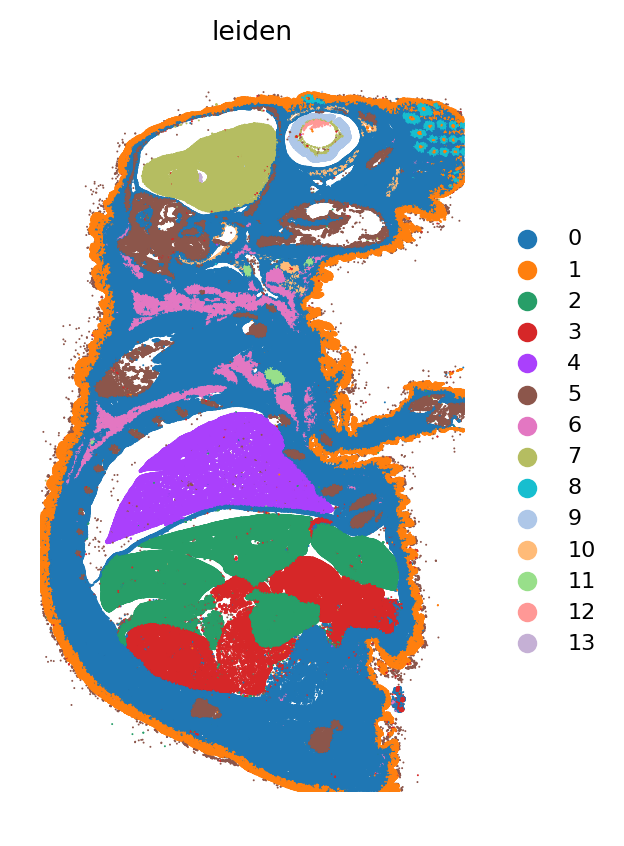

In [23]:
import matplotlib.pyplot as plt


plt.rcParams['font.size'] = 8
s=2
title_size = 15
f,ax=plt.subplots(1,1,figsize=(3,5),dpi=200)
sc.pl.embedding(strna,  basis="spatial",color=['leiden'], title=['leiden'],  legend_fontsize=8,
              show=False, frameon=False, s=s,ax=ax)
plt.show()

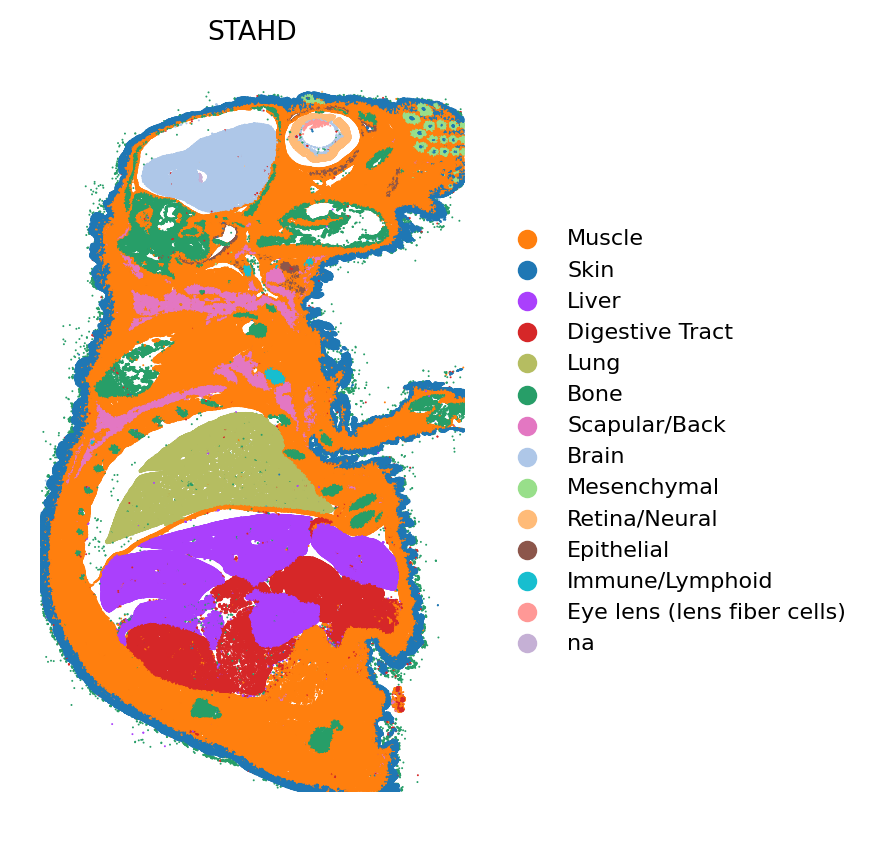

In [26]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scanpy.pl.palettes import default_20
mapping_dict = {
    '0': "Muscle",
    '1': "Skin",
    '2': "Liver",
    '3': "Digestive Tract",
    '4': "Lung",
    '5': "Bone",
    '6': "Scapular/Back",
    '7': "Brain",
    '8': "Mesenchymal",
    '9': "Retina/Neural",
    '10': "Epithelial",
    '11': "Immune/Lymphoid",
    '12': "Eye lens (lens fiber cells)",
     '13': "na"
}
strna.obs["region"] = strna.obs["leiden"].map(mapping_dict)

unique_regions = strna.obs["region"].unique().tolist()
color_dict1 = dict(zip(unique_regions, default_20[:len(unique_regions)]))
# strna.obsm["spatial"][:, 1] = -strna.obsm["spatial"][:, 1]
fig, ax= plt.subplots(1, 1, figsize=(3, 5), dpi=200)
sc.pl.embedding(strna,  basis="spatial",color=['region'], title=['STAHD'],  legend_fontsize=8,
              show=False, frameon=False, s=s,ax=ax)
plt.show()


# Data denoising

In [3]:
adata.var_names_make_unique()
adata = adata[:,np.sum(adata.X,axis=0)>0]
adata = adata[np.sum(adata.X,axis=1)>0]
adata.layers["Raw"] = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 1296241 × 5010
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Spatial_Net', 'adj', 'edgeList', 'log1p'
    obsm: 'spatial'
    layers: 'Raw'

In [4]:
import screcode
recode = screcode.RECODE(seq_target='RNA',version=1,fast_algorithm_ell_ub=1000)
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data


Acceleration error: the optimal value of ell is larger than fast_algorithm_ell_ub. Set larger fast_algorithm_ell_ub than 1000 or 'fast_algorithm=False'


end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 5010, '#non-significant genes': 0, '#silent genes': 0, 'ell': 999, 'Elapsed time': '0h 35m 41s 948ms', 'solver': 'randomized', '#test_data': 259248}


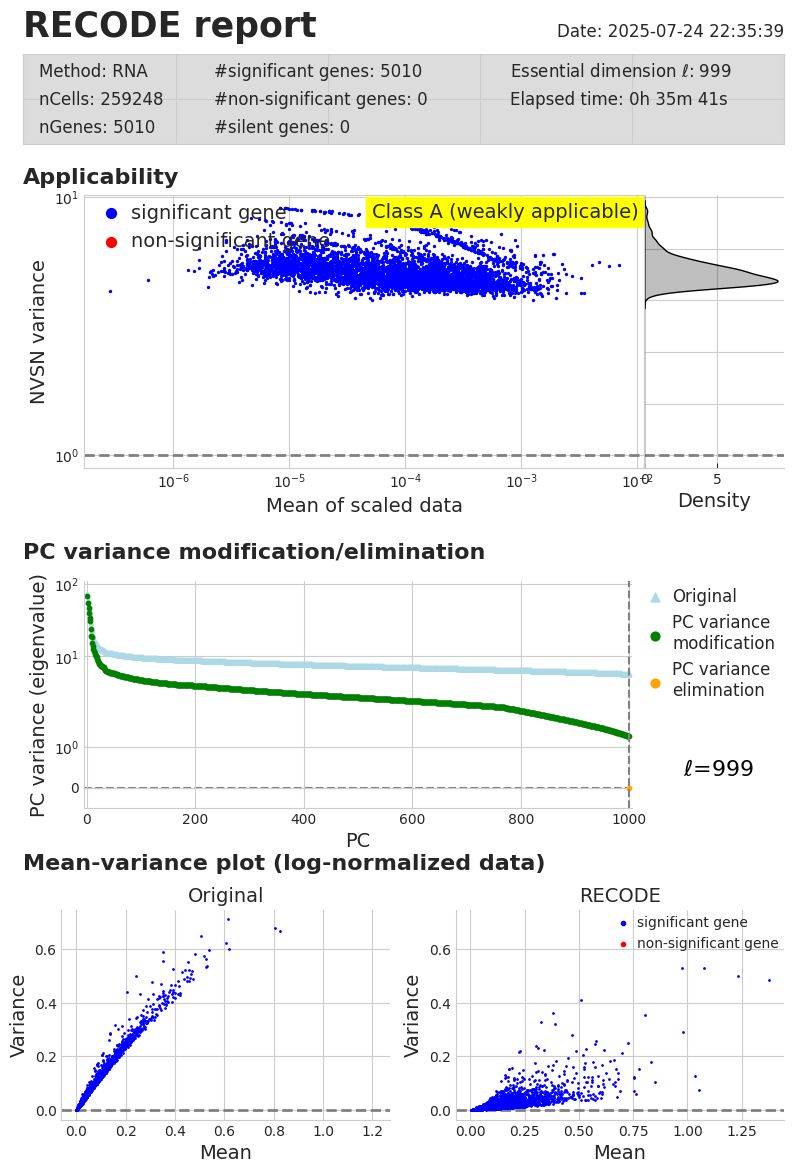

In [5]:
recode.report()

## Log normalizaation

In [6]:
target_sum = np.median(np.sum(adata.layers["RECODE"],axis=1))
adata = recode.lognormalize(adata,target_sum=target_sum)
print(np.median(np.sum(adata.layers["RECODE"],axis=1)))

Normalized data are stored in "RECODE_norm" and "RECODE_log"
770.77149


In [7]:
adata.layers["Raw_norm"] = target_sum*adata.layers["Raw"]/np.sum(adata.layers["Raw"],axis=1)[:,np.newaxis]
adata.layers["Raw_log"] = np.log(adata.layers["Raw_norm"]+1)

## Plot spatial gene expression

0.0 2.6655506917505423
0.0 1.0099564695719447
0.0 1.5834807352951947
0.0 0.8634904325427231


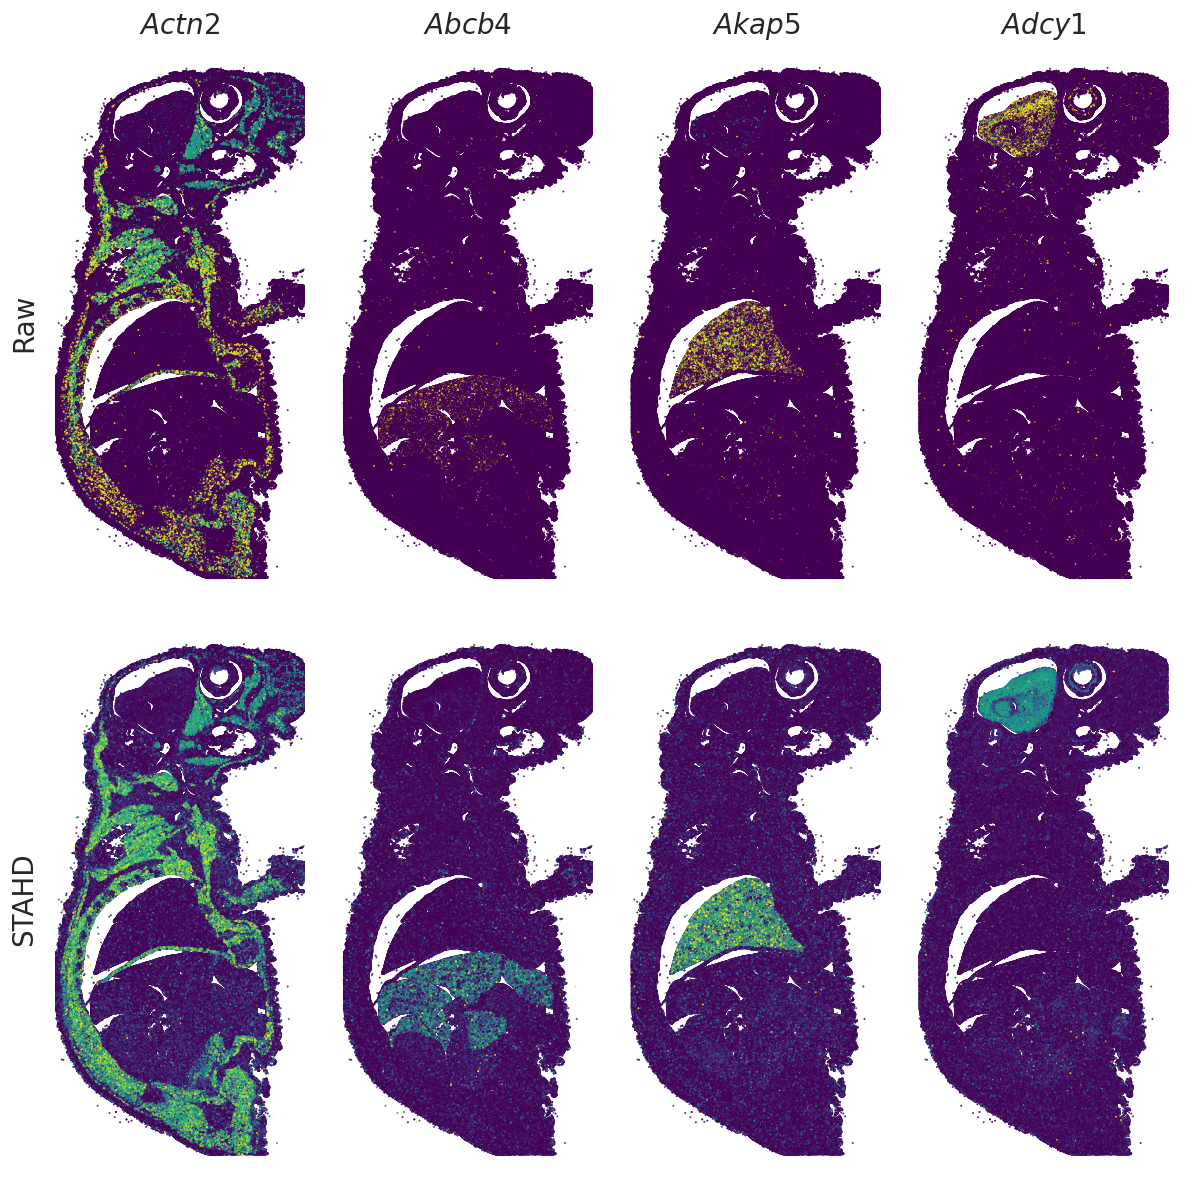

In [14]:
import matplotlib.pyplot as plt
def spatial_gex(
        genes,
        sp_x = adata.obs["x_centroid"],
        sp_y = adata.obs["y_centroid"],
        psize = 0.2,
        figsize=(3,6),
        dpi=100,
        percentiles = [0,100],
        fs_title = 20,
        fs_label = 20,
    ):

    fig,ax = plt.subplots(2,len(genes),figsize=(figsize[0]*len(genes),figsize[1]*2),tight_layout=True)
    adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]
    for i in range(len(genes)):
        idx_gene = adata.var.index == genes[i]
        if sum(idx_gene) == 0: continue
        exp = adata.layers["RECODE_log"][:,idx_gene]
        exp1 = adata.layers["Raw_log"][:,idx_gene]
        #vmin,vmax = np.percentile(exp,percentiles[0]),np.percentile(exp,percentiles[1])

        vmin,vmax=max(exp.min(),exp1.min()),min(exp.max(),exp1.max())-1
        print(vmin,vmax)
        ax_ = ax[1,i]
        ax_.scatter(sp_x, sp_y,c=exp,s=psize,marker="H",vmin=vmin,vmax=vmax,cmap='viridis')
        ax_.grid(False)
        if i== 0:
            ax_.set_ylabel("STAHD",fontsize=fs_label)
            ax_.tick_params(bottom=False, left=False, right=False, top=False,
                            labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            [ax_.spines[c_].set_visible(False) for c_ in ['right','top','bottom','left']]
        else:
            ax_.axis('off')


        exp = adata.layers["Raw_log"][:,idx_gene]
        ax_ = ax[0,i]
        ax_.scatter(sp_x, sp_y,c=exp,s=psize,marker="H",vmin=vmin,vmax=vmax,cmap='viridis')
        ax_.set_title("$\it{%s}$" % genes[i],fontsize=fs_title)
        ax_.grid(False)
        if i== 0:
            ax_.set_ylabel("Raw",fontsize=fs_label)
            ax_.tick_params(bottom=False, left=False, right=False, top=False,
                            labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            [ax_.spines[c_].set_visible(False) for c_ in ['right','top','bottom','left']]

        else:
            ax_.axis('off')

GENES = ['Actn2','Abcb4','Akap5','Adcy1']

n_plots = 4
for i in range(int(len(GENES)/n_plots+0.9)):
    if (i+1)*n_plots < len(GENES):
        genes = GENES[i*n_plots:(i+1)*n_plots]
    else:
        genes = GENES[i*n_plots:len(GENES)]
    # spatial_gex(genes,adata.obs["x_centroid"], -adata.obs["y_centroid"], figsize=(6,3))
    spatial_gex(genes = genes)